### Après avoir effectué un nettoyage approfondi des données et identifié les variables prédictives disponibles avant l'accouchement (lors de l'admission en salle de naissance), nous allons explorer différents modèles de classification en commençant par la régression logistique, qui offre une bonne interprétabilité. Notre variable cible binaire, hpp_trans (Hémorragie post-partum nécessitant une transfusion), présente un fort déséquilibre avec seulement 0.78% de cas positifs. Pour permettre au modèle de détecter efficacement le signal dans ces données déséquilibrées, nous allons tester plusieurs techniques de rééquilibrage.

### Notre approche sera progressive :
### 1. Évaluation du modèle de base sans rééquilibrage
### 2. Test de différentes techniques de rééquilibrage (sur-échantillonnage de la classe minoritaire, sous-échantillonnage de la classe majoritaire et pondération des classes)
### 3. Optimisation des hyperparamètres via GridSearch en considérant le score F1 et le recall
 
### Dans ce contexte médical où une mauvaise classification peut avoir des conséquences graves, nous privilégierons l'optimisation du recall tout en maintenant une précision acceptable. Les performances seront évaluées entre autres à l'aide des courbes ROC et precision-recall. Bien que le seuil de décision soit initialement fixé à 0.5, nous explorerons différents seuils pour optimiser les résultats.

In [35]:
# Bibliothèques standards
import logging
import os


# Bibliothèques de données et calcul scientifique
import joblib
import numpy as np
import pandas as pd
import seaborn as sns

# Visualisation
import matplotlib.pyplot as plt

# MLflow
import mlflow
import mlflow.data.pandas_dataset
import mlflow.sklearn

# Scikit-learn - Prétraitement
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,FunctionTransformer

# Scikit-learn - Modélisation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                   StratifiedKFold, train_test_split,cross_validate)
from sklearn.pipeline import Pipeline

# Scikit-learn - Métriques
from sklearn.metrics import (ConfusionMatrixDisplay, auc, classification_report,
                           f1_score, make_scorer, precision_recall_curve,
                           precision_score, recall_score, roc_auc_score,
                           roc_curve)

# Scikit-learn - Métriques d'évaluation supplémentaires
from sklearn.metrics import confusion_matrix,accuracy_score,balanced_accuracy_score,classification_report,roc_auc_score,roc_curve,precision_recall_curve,f1_score,recall_score,precision_score


# Imbalanced-learn
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# XGBoost
from xgboost import XGBClassifier

# Suppression des avertissements liés à la dépréciation
import warnings

os.environ["PYTHONWARNINGS"] = "ignore"


warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*_validate_data.*")
warnings.filterwarnings("ignore", message=".*_check_n_features.*")
warnings.filterwarnings("ignore", message=".*_check_feature_names.*")
warnings.filterwarnings("ignore", message=".*force_all_finite.*")
warnings.filterwarnings("ignore", message=".*ensure_all_finite.*")

In [36]:
df_dico = pd.read_csv('Project/clean/description_variable_clean.csv',index_col=0)
df_model = pd.read_csv('Project/clean/Bourgogne20132023_clean.csv', index_col=0)

In [37]:
# Fonction pour mettre à jour les listes de features en fonction du dictionnaire de variables
def update_list_features(X_train, df_dico):
    df_dico = df_dico.reindex(X_train.columns)
    quant_features = df_dico[df_dico['type_var'] == 'Quantitative'].index.tolist()
    binary_features = df_dico[df_dico['type_var'] == 'Binaire'].index.tolist()
    nominal_features = df_dico[df_dico['type_var'] == 'Nominale'].index.tolist()
    ordinal_features = df_dico[df_dico['type_var'] == 'Ordinale'].index.tolist()
    return quant_features, binary_features, nominal_features, ordinal_features

In [38]:
df_dico

,count,value_counts,nunique,min,max,description,type_var
bmi,53061,NaN,359,12.0,50.0,"L'indice de masse corporelle (IMC, ou BMI en a...",Quantitative
terme,65534,NaN,172,22.0,43.0,Terme à l'accouchement en semaine d aménorrhée...,Quantitative
dsm_g,65494,NaN,88,0.0,102.0,Duree hosp. pendant la grossesse,Quantitative
taille_mere,53227,NaN,55,109.0,190.0,Taille de la mére (en cm),Quantitative
age_m,65534,NaN,42,12.0,62.0,Age maternel calculé à partir de la date de na...,Quantitative
parite,54213,NaN,14,0.0,23.0,Parité obstétricale : nombre d'enfants issues ...,Quantitative
nbilan,65534,NaN,12,0.0,16.0,Nb bilans au cours de la grossesse,Quantitative
hosp_m_g,65534,NaN,10,0.0,9.0,Hosp. pendant la grossesse (0 : Non/1 : Oui),Quantitative
nsej18,65534,"{0: 61524, 1: 3477, 2: 416, 3: 88, 4: 20, 5: 7...",8,0.0,8.0,Nb sejours < 18 SA,Quantitative
AMP,65534,"{'Aucune': 64379, 'FIV': 353, 'FIV ICSI': 229,...",6,NaN,NaN,"Aide médicale à la procréation (FIV, ICSI, TEC...",Nominale


In [39]:
df_model=df_model.dropna()

X=df_model.drop(['hpp_trans'],axis=1)
y=df_model["hpp_trans"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

quant_features, binary_features, nominal_features, ordinal_features = update_list_features(X_train, df_dico)

print('Nombre de lignes et de colonnes de X_train : ',X_train.shape,'\n')


print(X_train[:5])

print("Quantitative features : ",quant_features)
print("Binaire features : ",binary_features)
print("Nominal features : ",nominal_features)
print("Ordinale features : ",ordinal_features)



Nombre de lignes et de colonnes de X_train :  (42350, 22) 

       age_m  taille_mere   bmi  tabac  parite  diabete  hta_tot  cholestase  \
45967   36.0        160.0  30.9      0     9.0        0        0           0   
1953    24.0        164.0  21.9      0     0.0        0        0           0   
9096    32.0        160.0  25.4      0     1.0        0        0           0   
43484   37.0        163.0  18.8      0     2.0        0        0           0   
44651   35.0        161.0  32.8      0     1.0        0        0           0   

       preecl  hellp  ...  ut_cica  cortico     AMP  pma hosp_m_g  dsm_g  \
45967       0      0  ...        1        0  Aucune    0        0    0.0   
1953        0      0  ...        0        0  Aucune    0        0    0.0   
9096        0      0  ...        1        0  Aucune    0        0    0.0   
43484       0      0  ...        0        1  Aucune    0        1    4.0   
44651       0      0  ...        0        0  Aucune    0        0    0.0   

  

In [40]:
# Création des transformateurs pour chaque type de variable

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False))
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Création du preprocesseur avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, quant_features),
        ("bin", "passthrough", binary_features), 
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer, ordinal_features)
    ])




In [41]:
def evaluate_model(model, X_train, X_test, y_train, y_test, experiment_name="Default", run_name="Default Run", use_mlflow=False, display_plots=True):
    """
    Évalue un modèle entraîné et génère différents graphiques et métriques avec tracking MLflow optionnel
    
    Args:
        model: Le modèle à évaluer
        X_train, X_test, y_train, y_test: Données d'entraînement et de test
        experiment_name: Nom de l'expérience MLflow
        run_name: Nom de l'exécution MLflow
        use_mlflow: Booléen indiquant si les résultats doivent être enregistrés dans MLflow
        display_plots: Booléen indiquant si les graphiques doivent être affichés
    """

    figures_train = []
    figures_test = []
    metrics_train = {}
    metrics_test = {}
    
    # Prédictions et probabilités
    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_prob_train = model.predict_proba(X_train)[:, 1]
    
    # Prédictions avec seuil 0.5
    y_pred_test = (y_prob_test > 0.5).astype(int)
    y_pred_train = (y_prob_train > 0.5).astype(int)

    # Calcul des métriques de base
    metrics_train["recall"] = round(recall_score(y_train, y_pred_train), 4)
    metrics_train["precision"] = round(precision_score(y_train, y_pred_train), 4) 
    metrics_train["f1"] = round(f1_score(y_train, y_pred_train), 4)
    
    metrics_test["recall"] = round(recall_score(y_test, y_pred_test), 4)
    metrics_test["precision"] = round(precision_score(y_test, y_pred_test), 4)
    metrics_test["f1"] = round(f1_score(y_test, y_pred_test), 4)
    


    # Matrice de confusion normalisée train
    fig_train = plt.figure(figsize=(6, 5))
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_norm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm_train, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"{run_name}\nMatrice de confusion normalisée (Train)")
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.tight_layout()
    figures_train.append(("confusion_matrix_train.png", fig_train))
    plt.close(fig_train)
    
    # Matrice de confusion normalisée test
    fig_test = plt.figure(figsize=(6, 5))
    cm_test = confusion_matrix(y_test, y_pred_test)
    cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm_test, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"{run_name}\nMatrice de confusion normalisée (Test)")
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.tight_layout()
    figures_test.append(("confusion_matrix_test.png", fig_test))
    plt.close(fig_test)
    
    # Affichage côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Afficher la matrice train dans la première colonne
    sns.heatmap(cm_norm_train, annot=True, fmt='.2f', cmap='Blues', ax=axes[0])
    axes[0].set_title(f"{run_name}\nMatrice de confusion normalisée (Train)")
    axes[0].set_xlabel('Prédiction')
    axes[0].set_ylabel('Réalité')
    
    # Afficher la matrice test dans la deuxième colonne
    sns.heatmap(cm_norm_test, annot=True, fmt='.2f', cmap='Blues', ax=axes[1])
    axes[1].set_title(f"{run_name}\nMatrice de confusion normalisée (Test)")
    axes[1].set_xlabel('Prédiction')
    axes[1].set_ylabel('Réalité')
    
    plt.tight_layout()
    plt.show()
  


    # Courbes ROC
    fpr, tpr, _ = roc_curve(y_train, y_prob_train)
    metrics_train["roc_auc"] = round(roc_auc_score(y_train, y_prob_train), 4)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"ROC curve (AUC = {metrics_train['roc_auc']:.4f})")
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve - Train Set - {run_name}")
    ax.legend()
    figures_train.append(("roc_curve.png", fig))
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    metrics_test["roc_auc"] = round(roc_auc_score(y_test, y_prob_test), 4)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label=f"ROC curve (AUC = {metrics_test['roc_auc']:.4f})")
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve - Test Set - {run_name}")
    ax.legend()
    figures_test.append(("roc_curve.png", fig))
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    # Courbes Precision-Recall
    train_precision, train_recall, _ = precision_recall_curve(y_train, y_prob_train)
    metrics_train["pr_auc"] = round(auc(train_recall, train_precision), 4)
    fig, ax = plt.subplots()
    ax.plot(train_recall, train_precision, lw=2, label=f"PR curve (AUC = {metrics_train['pr_auc']:.4f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve - Train Set - {run_name}")
    ax.legend()
    ax.grid()
    figures_train.append(("precision_recall_curve.png", fig))
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    test_precision, test_recall, _ = precision_recall_curve(y_test, y_prob_test)
    metrics_test["pr_auc"] = round(auc(test_recall, test_precision), 4)
    fig, ax = plt.subplots()
    ax.plot(test_recall, test_precision, lw=2, label=f"PR curve (AUC = {metrics_test['pr_auc']:.4f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve - Test Set - {run_name}")
    ax.legend()
    ax.grid()
    figures_test.append(("precision_recall_curve.png", fig))
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    # Distribution des probabilités (seulement classe 1)
    fig, ax = plt.subplots()
    ax.hist(y_prob_train[y_train == 1], bins=20, alpha=0.5, label='Classe 1', color='red')
    ax.set_title(f"Distribution des probabilités - Classe 1 (Train) - {run_name}")
    ax.set_xlabel('Probabilité prédite')
    ax.set_ylabel('Nombre d\'échantillons')
    ax.legend()
    figures_train.append(("distribution_proba.png", fig))
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
    
    fig, ax = plt.subplots()
    ax.hist(y_prob_test[y_test == 1], bins=20, alpha=0.5, label='Classe 1', color='red')
    ax.set_title(f"Distribution des probabilités - Classe 1 (Test) - {run_name}")
    ax.set_xlabel('Probabilité prédite')
    ax.set_ylabel('Nombre d\'échantillons')
    ax.legend()
    figures_test.append(("distribution_proba.png", fig))
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    # Test de différents seuils
    seuils = np.arange(0.1, 1.0, 0.1)
    recalls_test = []
    precisions_test = []
    f1_scores_test = []

    for seuil in seuils:
        y_pred_test = (y_prob_test > seuil).astype(int)
        recall = round(recall_score(y_test, y_pred_test, zero_division=0), 4)
        precision = round(precision_score(y_test, y_pred_test, zero_division=0), 4)
        f1 = round(f1_score(y_test, y_pred_test, zero_division=0), 4)
        
        recalls_test.append(recall)
        precisions_test.append(precision)
        f1_scores_test.append(f1)
        
        metrics_test[f"recall_seuil_{seuil:.1f}"] = recall
        metrics_test[f"precision_seuil_{seuil:.1f}"] = precision
        metrics_test[f"f1_seuil_{seuil:.1f}"] = f1

    # Graphique seuils
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(seuils, recalls_test, label="Recall", marker="o")
    ax.plot(seuils, precisions_test, label="Precision", marker="o")
    ax.plot(seuils, f1_scores_test, label="F1-Score", marker="o")
    ax.set_xlabel("Seuil de décision")
    ax.set_ylabel("Métrique")
    ax.set_title(f"Évolution des métriques en fonction du seuil (Test Set) - {run_name}")
    ax.legend()
    ax.grid(True)
    figures_test.append(("threshold_search.png", fig))
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    # Feature Importance
    try:
        if isinstance(model, GridSearchCV):
            best_model = model.best_estimator_
        else:
            best_model = model
            
        feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
        
        # Obtenir l'importance des features selon le type de modèle
        if hasattr(best_model.named_steps["classifier"], "coef_"):
            # Pour LogisticRegression
            importance = best_model.named_steps["classifier"].coef_[0]
            importance_type = "Coefficient"
        elif hasattr(best_model.named_steps["classifier"], "feature_importances_"):
            # Pour RandomForest et XGBoost
            importance = best_model.named_steps["classifier"].feature_importances_
            importance_type = "Importance"
        else:
            raise AttributeError("Le modèle ne supporte pas l'importance des features")

        feature_importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importance,
            "Absolute_Importance": np.abs(importance),
        }).sort_values(by="Absolute_Importance", ascending=False)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.barh(feature_importance_df["Feature"], feature_importance_df["Absolute_Importance"])
        ax.set_xlabel(f"Absolute {importance_type} Value")
        ax.set_ylabel("Feature")
        ax.set_title(f"Feature Importance - {best_model.named_steps['classifier'].__class__.__name__} - {run_name}")
        ax.invert_yaxis()
        plt.tight_layout()
        # Cette figure n'est pas spécifique au train ou test, on la met dans les deux
        figures_train.append(("feature_importance.png", fig))
        figures_test.append(("feature_importance.png", fig))
        if display_plots:
            plt.show()
        else:
            plt.close(fig)
    except (AttributeError, KeyError) as e:
        print(f"Impossible d'afficher l'importance des features: {str(e)}")

    # Classification reports
    report_train = classification_report(y_train, y_pred_train, zero_division=0)
    report_test = classification_report(y_test, y_pred_test, zero_division=0)

    # print('report_train','\n',report_train)
    # print('report_test','\n',report_test)

    # Pour compatibilité avec le code existant, on crée une liste combinée de figures
    figures = []
    for i, (name, fig) in enumerate(figures_train):
        figures.append((f"01-{i+1}-train_{name}", fig))
    for i, (name, fig) in enumerate(figures_test):
        figures.append((f"02-{i+1}-test_{name}", fig))

    # Enregistrement dans MLflow si use_mlflow est True
    if use_mlflow:
        mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "https://thibautmodrin-mlflow.hf.space"))
        mlflow.set_experiment(experiment_name)
        mlflow.sklearn.autolog(disable=True)
        
        with mlflow.start_run(run_name=run_name):
            # Log des paramètres
            mlflow.log_params(model.get_params())

            # Log du modèle
            if isinstance(model, GridSearchCV):
                best_model = model.best_estimator_
            else:
                best_model = model
                
            signature = mlflow.models.infer_signature(
                best_model.named_steps['preprocessor'].transform(X_train),
                best_model.predict(X_train)
            )
            mlflow.sklearn.log_model(best_model, best_model.__class__.__name__, signature=signature)
            
            # Log des datasets
            for col in X_train.select_dtypes(include=['int']).columns:
                X_train[col] = X_train[col].astype(float)
            y_train = y_train.astype(float)
            mlflow.log_input(mlflow.data.pandas_dataset.from_pandas(X_train, name="X_train"))
            mlflow.log_input(mlflow.data.pandas_dataset.from_pandas(pd.DataFrame(y_train), name="y_train"))
            
            # Log des métriques
            all_metrics = {}
            for k, v in metrics_train.items():
                all_metrics[f"{k}_train"] = v
            for k, v in metrics_test.items():
                all_metrics[f"{k}_test"] = v
            mlflow.log_metrics(all_metrics)
            
            # Log des figures
            for name, fig in figures:
                mlflow.log_figure(fig, name)
                
            # Log des rapports
            mlflow.log_text(report_train, "11-classification_report_train.txt")
            mlflow.log_text(report_test, "12-classification_report_test.txt")

    # Retourner un dictionnaire avec le nom du run et les métriques et figures associées pour comparer les modèles
    return {
        'run_name': run_name,
        'metrics_train': metrics_train,
        'metrics_test': metrics_test,
        'figures_train': figures_train,
        'figures_test': figures_test
    }

In [42]:
def figure_to_array(fig):
    """
    Convertit une figure matplotlib en tableau numpy pour l'affichage.
    
    Args:
        fig: Figure matplotlib
        
    Returns:
        Tableau numpy représentant l'image
    """
    from io import BytesIO
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Sauvegarder la figure dans un buffer
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=100)
    buf.seek(0)
    
    # Charger l'image depuis le buffer
    from PIL import Image
    img = Image.open(buf)
    return np.array(img)



def comparer_modeles_visuellement(model_list, filter_list=None, modeles_en_lignes=True):
    """
    Crée une visualisation comparative des figures de test pour plusieurs modèles.
    
    Args:
        model_list: Liste des résultats de modèles (dictionnaires avec 'run_name' et 'figures_test')
        filter_list: Liste optionnelle des noms de figures à afficher (filtre)
        modeles_en_lignes: Si True, les modèles sont en lignes et les figures en colonnes.
                          Si False, les modèles sont en colonnes et les figures en lignes.
    
    Returns:
        Une figure matplotlib avec les figures de test pour chaque modèle
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Récupérer les noms des modèles
    noms_modeles = [modele['run_name'] for modele in model_list]
    n_modeles = len(model_list)
    
    # Filtrer les figures selon filter_list
    figures_filtrees = []
    for modele in model_list:
        figures_modele = []
        for nom, fig in modele['figures_test']:
            if filter_list is None or nom in filter_list:
                figures_modele.append((nom, fig))
        figures_filtrees.append(figures_modele)
    
    # Vérifier qu'il y a des figures à afficher
    if not figures_filtrees[0]:
        print("Aucune figure ne correspond aux critères de filtrage.")
        return None
    
    # Récupérer les noms des figures filtrées
    noms_figures = [nom for nom, _ in figures_filtrees[0]]
    n_figures = len(noms_figures)
    
    # Création d'une figure avec une grille de sous-graphiques
    if modeles_en_lignes:
        # Modèles en lignes, figures en colonnes
        fig, axes = plt.subplots(n_modeles, n_figures, figsize=(n_figures*8, n_modeles*5))
    else:
        # Modèles en colonnes, figures en lignes
        fig, axes = plt.subplots(n_figures, n_modeles, figsize=(n_modeles*8, n_figures*5))
    
    # Ajuster les axes si un seul modèle ou une seule figure
    if n_modeles == 1 and n_figures == 1:
        axes = np.array([[axes]])
    elif n_modeles == 1:
        axes = axes.reshape(1, -1) if modeles_en_lignes else axes.reshape(-1, 1)
    elif n_figures == 1:
        axes = axes.reshape(-1, 1) if modeles_en_lignes else axes.reshape(1, -1)
    
    if modeles_en_lignes:
        # Pour chaque modèle (lignes)
        for i, modele in enumerate(model_list):
            # Pour chaque type de figure filtrée (colonnes)
            for j, (nom_figure, figure_obj) in enumerate(figures_filtrees[i]):
                # Afficher la figure dans le sous-graphique correspondant
                axes[i, j].imshow(figure_to_array(figure_obj))
                axes[i, j].axis('off')
    else:
        # Pour chaque type de figure (lignes)
        for j, nom_figure in enumerate(noms_figures):
            # Pour chaque modèle (colonnes)
            for i, modele in enumerate(model_list):
                # Afficher la figure dans le sous-graphique correspondant
                figure_obj = next((fig for nom, fig in figures_filtrees[i] if nom == nom_figure), None)
                if figure_obj:
                    axes[j, i].imshow(figure_to_array(figure_obj))
                    axes[j, i].axis('off')
                
                # Ajouter le nom du modèle comme titre de colonne (seulement pour la première ligne)
                if j == 0:
                    axes[j, i].set_title(modele['run_name'], fontsize=16, fontweight='bold')
                
                # Ajouter le nom de la figure comme étiquette de ligne (seulement pour la première colonne)
                if i == 0:
                    axes[j, i].set_ylabel(nom_figure, fontsize=14, fontweight='bold')
    
    # Ajuster l'espacement entre les sous-graphiques
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    
    return 

### 1. Test du modèle de référence pour établir notre baseline

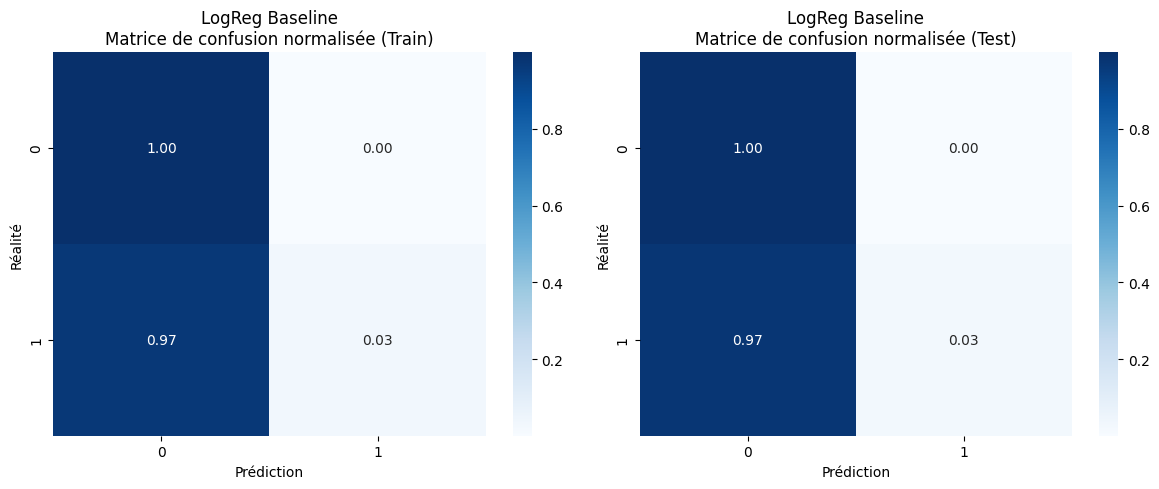

In [43]:
modeles=[]

model = LogisticRegression(random_state=42,max_iter=1000)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])
param_grid = {
    
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_reg_baseline=GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1',refit=True,return_train_score=True)
log_reg_baseline.fit(X_train,y_train)


# Évaluation du modèle de référence
dict_log_reg_baseline=evaluate_model(log_reg_baseline, X_train,X_test, y_train, y_test, run_name="LogReg Baseline",display_plots=False)

# Enregistrement du modèle dans une liste pour utilisation ultérieure avec visualiser_comparaison_modeles
modeles.append(dict_log_reg_baseline)


### 2. Test de différentes techniques de rééquilibrage

#### 2.1. Rééquilibrage par sur-échantillonnage de la classe minoritaire

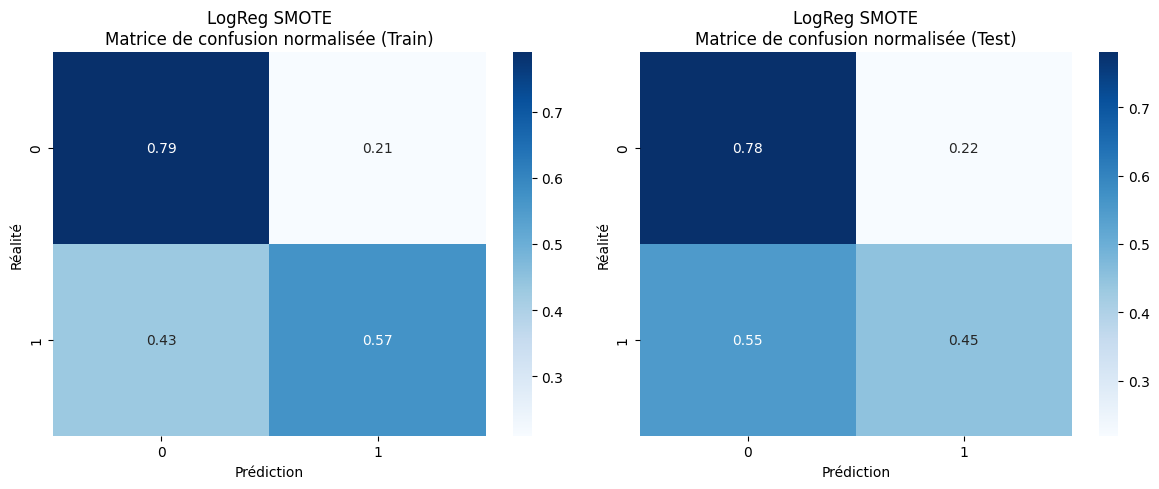

In [44]:



# Pipeline avec SMOTE
pipeline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42,max_iter=1000))
])

param_grid = {
    
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_reg_smote=GridSearchCV(pipeline_smote, param_grid, cv=cv, scoring='f1',refit=True,return_train_score=True)
log_reg_smote.fit(X_train,y_train)

# Évaluation du modèle
dict_log_reg_smote=evaluate_model(log_reg_smote, X_train,X_test, y_train, y_test, run_name="LogReg SMOTE",display_plots=False)

# Enregistrement du modèle dans la liste
modeles.append(dict_log_reg_smote)

#### 2.2. Rééquilibrage par sous-échantillonnage de la classe majoritaire

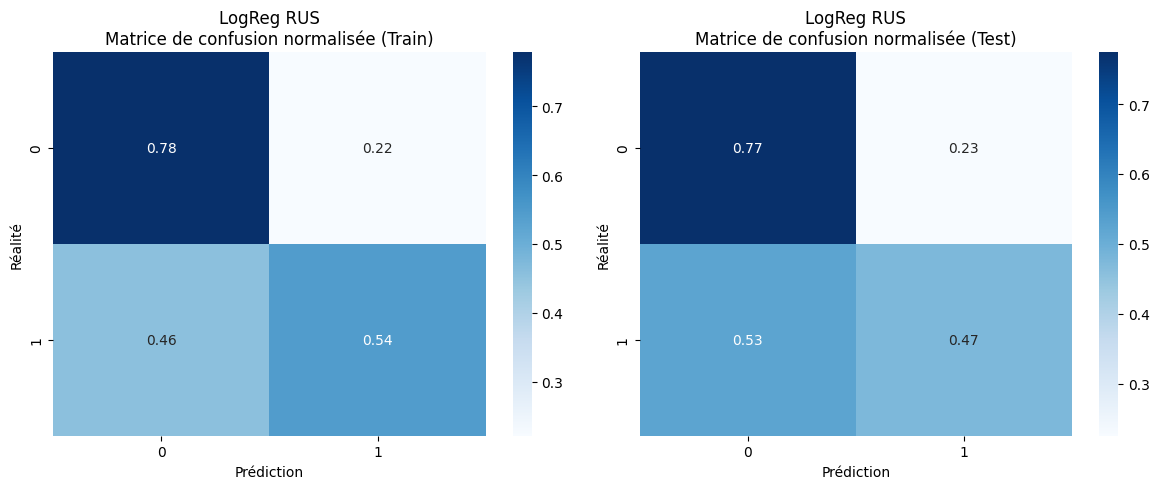

In [45]:


# Pipeline avec RandomUnderSampler
pipeline_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor), 
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegression(random_state=42,max_iter=1000))
])
param_grid = {
    
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_reg_rus=GridSearchCV(pipeline_rus, param_grid, cv=cv, scoring='f1',refit=True,return_train_score=True)
log_reg_rus.fit(X_train,y_train)

# Évaluation du modèle
dict_log_reg_rus=evaluate_model(log_reg_rus, X_train,X_test, y_train, y_test, run_name="LogReg RUS",display_plots=False)

# Enregistrement du modèle dans la liste
modeles.append(dict_log_reg_rus)

#### 2.3. Rééquilibrage Mixte

##### 2.3.1 SMOTEENN

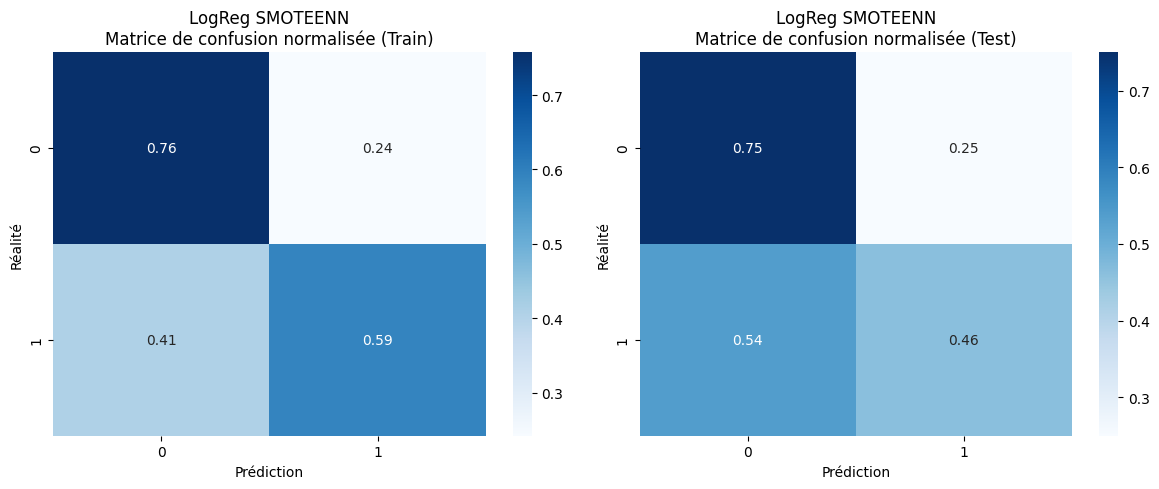

In [46]:


pipeline_smoteenn = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTEENN(random_state=42)),
    ('classifier', LogisticRegression(random_state=42,max_iter=1000))
])
param_grid = {
    
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_reg_smoteenn=GridSearchCV(pipeline_smoteenn, param_grid, cv=cv, scoring='f1',refit=True,return_train_score=True)
log_reg_smoteenn.fit(X_train,y_train)

# Évaluation du modèle
dict_log_reg_smoteenn=evaluate_model(log_reg_smoteenn, X_train,X_test, y_train, y_test, run_name="LogReg SMOTEENN",display_plots=False)

# Enregistrement du modèle dans la liste
modeles.append(dict_log_reg_smoteenn)

##### 2.3.2 SMOTETomek

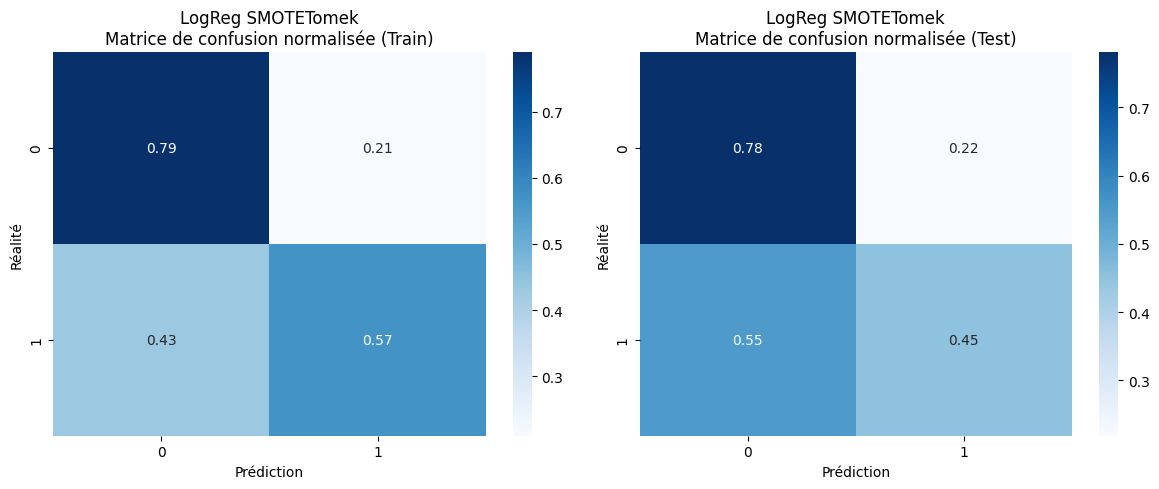

In [47]:
pipeline_smotetomek = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTETomek(random_state=42)),
    ('classifier', LogisticRegression(random_state=42,max_iter=1000))
])
param_grid = {
    
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_reg_smotetomek=GridSearchCV(pipeline_smotetomek, param_grid, cv=cv, scoring='f1',refit=True,return_train_score=True)
log_reg_smotetomek.fit(X_train,y_train)

# Évaluation du modèle
dict_log_reg_smotetomek=evaluate_model(log_reg_smotetomek, X_train,X_test, y_train, y_test, run_name="LogReg SMOTETomek",display_plots=False)

# Enregistrement du modèle dans la liste
modeles.append(dict_log_reg_smotetomek)

#### 2.4. Rééquilibrage par pondération des classes

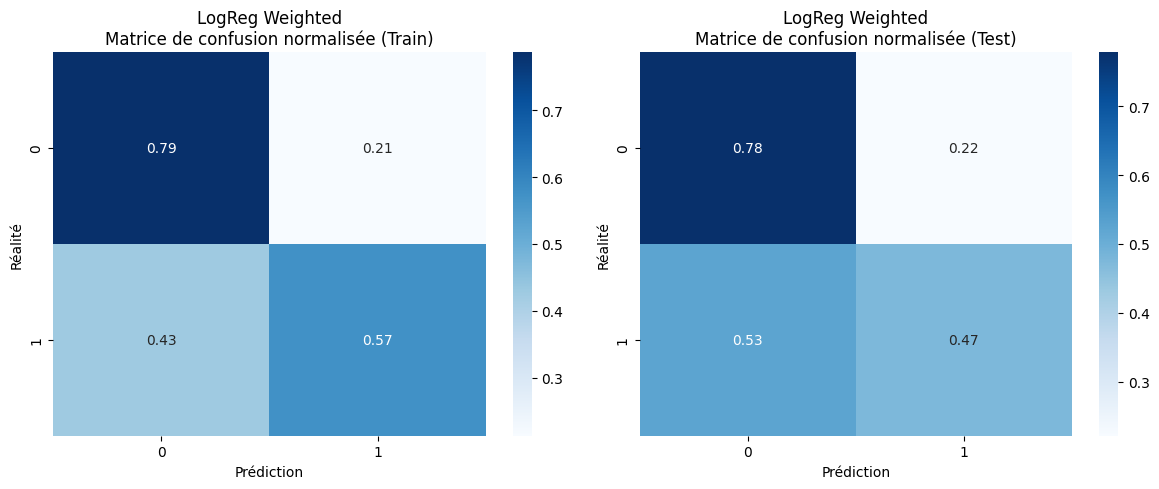

In [48]:
# Pipeline avec LogisticRegression pondérée
pipeline_weighted = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced',max_iter=1000))
])
param_grid = {
    
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
log_reg_weighted=GridSearchCV(pipeline_weighted, param_grid, cv=cv, scoring='f1',refit=True,return_train_score=True)
log_reg_weighted.fit(X_train,y_train)


# Evaluation du modèle
dict_log_reg_weighted=evaluate_model(log_reg_weighted, X_train,X_test, y_train, y_test, run_name="LogReg Weighted",display_plots=False)

# Enregistrement du modèle dans la liste
modeles.append(dict_log_reg_weighted)

### Graphique pour comparer les différentes méthodes d'échantillonnage et la baseline

In [49]:
def comparer_methodes_echantillonnage(modeles):
    """
    Crée des graphiques pour comparer les différentes méthodes d'échantillonnage.
    
    Parameters:
    -----------
    modeles : list
        Liste de dictionnaires contenant les informations des modèles à comparer
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Récupération des noms des modèles
    modeles_noms = [modele['run_name'] for modele in modeles]
    
    # Extraction des métriques pour chaque modèle
    precision_train = [modele['metrics_train']['precision'] for modele in modeles]
    recall_train = [modele['metrics_train']['recall'] for modele in modeles]
    f1_train = [modele['metrics_train']['f1'] for modele in modeles]
    
    precision_test = [modele['metrics_test']['precision'] for modele in modeles]
    recall_test = [modele['metrics_test']['recall'] for modele in modeles]
    f1_test = [modele['metrics_test']['f1'] for modele in modeles]
    
    # Création d'un dictionnaire pour stocker les métriques d'entraînement et de test
    metriques_train = {
        'Precision': precision_train,
        'Recall': recall_train,
        'F1-Score': f1_train,
    }
    
    metriques_test = {
        'Precision': precision_test,
        'Recall': recall_test,
        'F1-Score': f1_test,
    }
    
    # Couleurs pour les différentes métriques
    couleurs = ['#3498db', '#2ecc71', '#9b59b6']  # bleu, vert, violet
    
    # Graphique pour les métriques d'entraînement
    fig1 = plt.figure(figsize=(10, 6))
    x = np.arange(len(modeles_noms))
    largeur = 0.25
    
    for i, metrique in enumerate(['Precision', 'Recall', 'F1-Score']):
        plt.bar(x + (i-1)*largeur, metriques_train[metrique], width=largeur, 
                label=metrique, color=couleurs[i], alpha=0.8)
    
    plt.xlabel('Méthodes d\'échantillonnage', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Comparaison des méthodes d\'échantillonnage - Métriques d\'entraînement', fontsize=14)
    plt.xticks(x, modeles_noms, rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Graphique pour les métriques de test
    fig2 = plt.figure(figsize=(10, 6))
    
    for i, metrique in enumerate(['Precision', 'Recall', 'F1-Score']):
        plt.bar(x + (i-1)*largeur, metriques_test[metrique], width=largeur, 
                label=metrique, color=couleurs[i], alpha=0.8)
    
    plt.xlabel('Méthodes d\'échantillonnage', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Comparaison des méthodes d\'échantillonnage - Métriques de test', fontsize=14)
    plt.xticks(x, modeles_noms, rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()


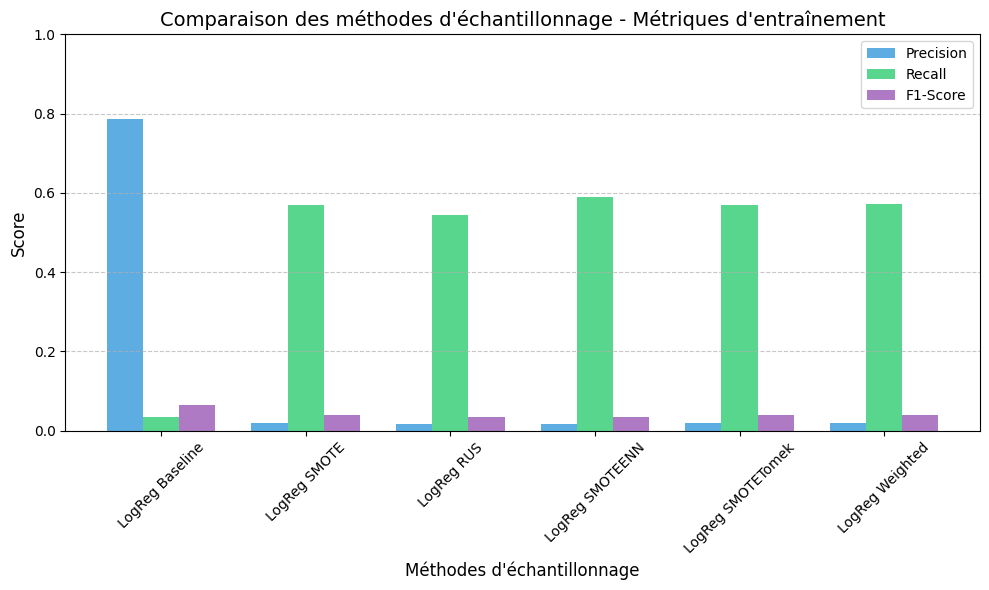

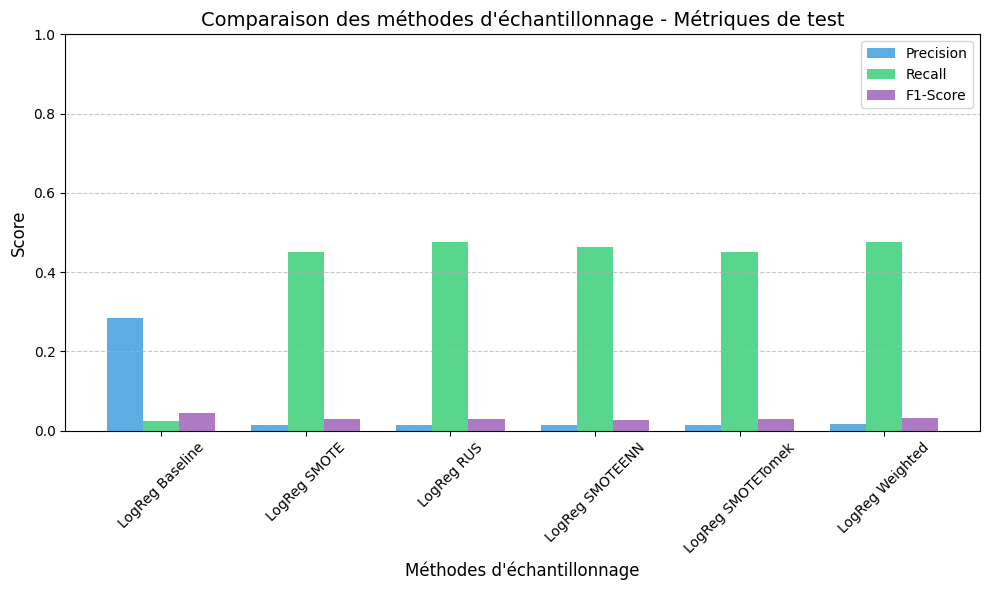

In [50]:
comparer_methodes_echantillonnage(modeles)

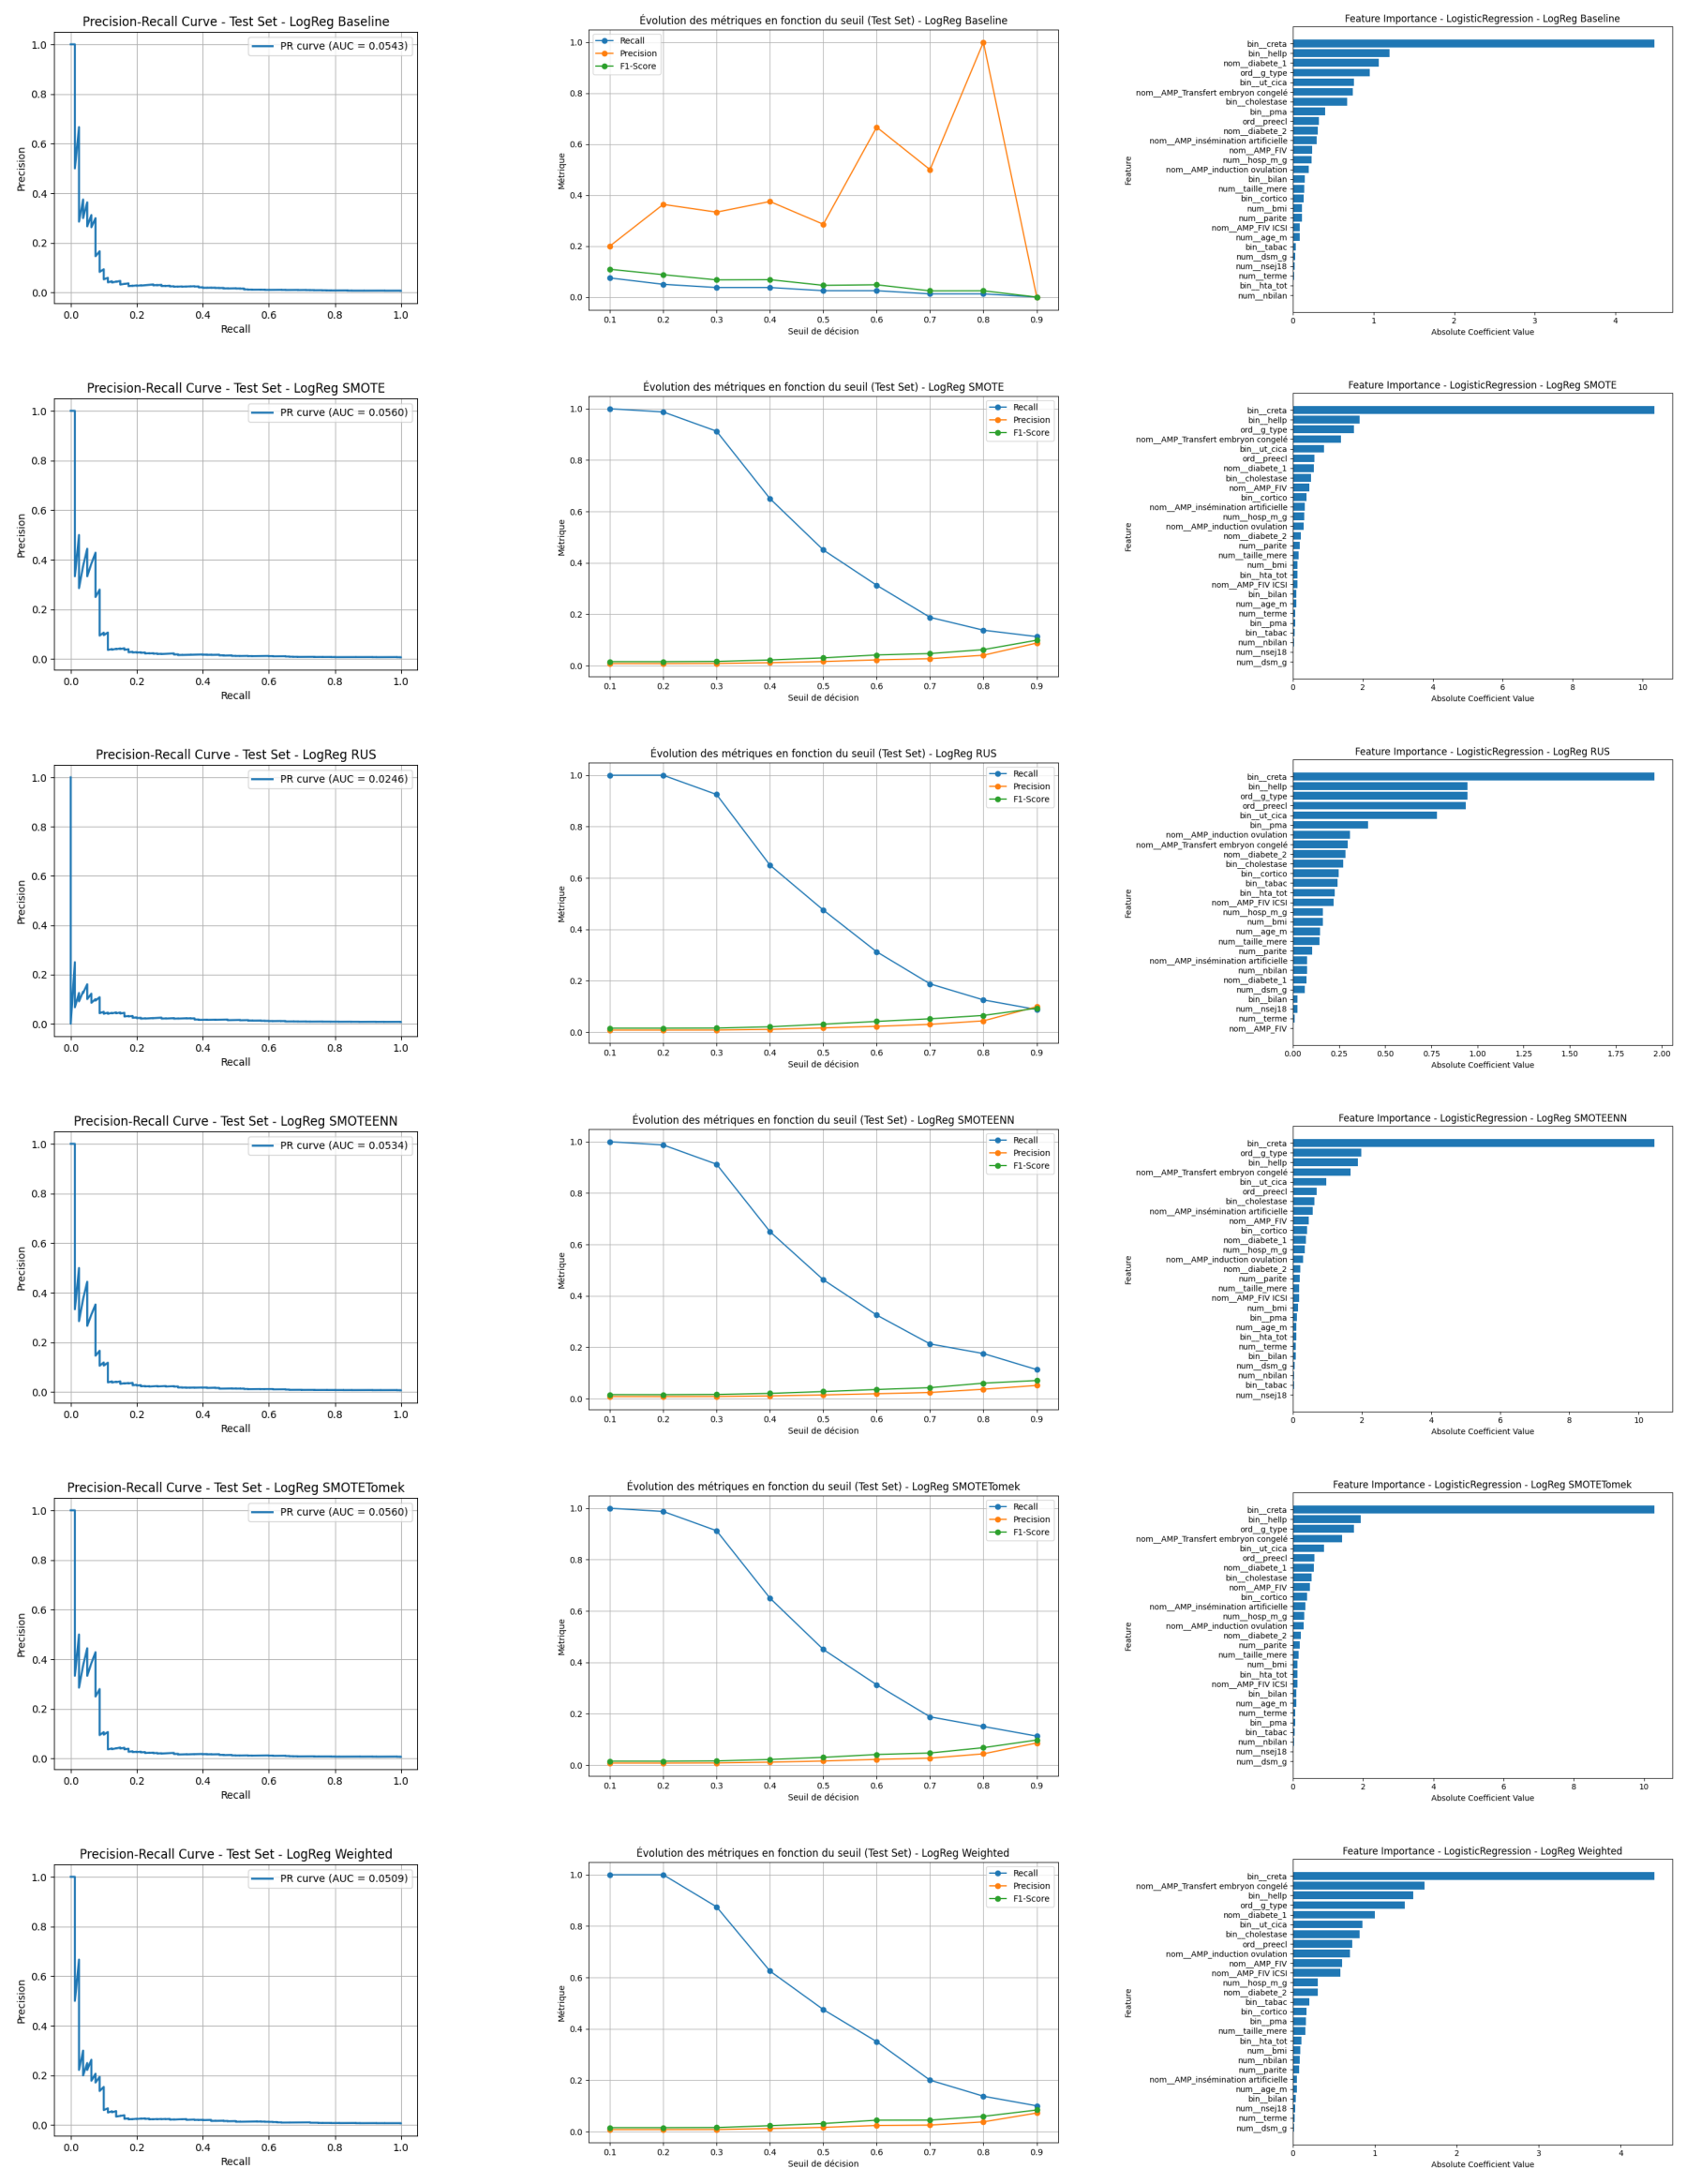

In [51]:


comparer_modeles_visuellement(modeles,filter_list=['precision_recall_curve.png','feature_importance.png','threshold_search.png'],modeles_en_lignes=True)


### Notre évaluation a mis en évidence l'influence des différentes méthodes d'échantillonnage (avec paramètres par défaut) sur la prédiction (X_test), à travers notamment le F1-score. 

### Notre analyse révèle que le modèle sans rééquilibrage des classes présente un F1-score légèrement supérieur. Cependant, en examinant plus précisément le trade-off precision/recall, nous observons que ce modèle privilégie fortement la détection de la classe majoritaire au détriment de la classe minoritaire ( 30% precision vs 5% recall). À l'inverse, les différentes méthodes de rééquilibrage favorisent le recall dans des proportions similaires (5% precision vs 50% recall).
### 
### L'analyse de l'impact du seuil de décision sur le trade-off precision/recall montre qu'il est possible d'améliorer considérablement le recall en abaissant le seuil vers 0, sans toutefois améliorer la précision.
###
### D'un point de vue opérationnel, nous devons nous interroger sur la pertinence de prédire tous les cas d'HPP sévère si cela implique également de classifier comme positives de nombreuses patientes sans risque réel. Une telle approche obligerait systématiquement l'équipe médicale à se préparer à cette éventualité pour toutes les patientes, ce qui pourrait s'avérer contre-productif, voire même avoir un impact négatif sur la prise en charge globale.


### Afin d'approfondir notre analyse et d'obtenir des résultats plus précis, nous allons utiliser une GridSearch pour identifier la méthode d'échantillonnage optimale ainsi que les hyperparamètres les plus performants. Notre objectif principal est d'améliorer le F1-Score, tout en surveillant attentivement le trade-off precision/recall, un aspect crucial dans notre contexte médical.


### En raison des contraintes de ressources informatiques, nous privilégierons une stratégie ciblée pour tester différentes combinaisons de paramètres. L'utilisation de RandomizedSearch constitue une alternative pertinente pour optimiser notre approche en évitant une consommation excessive de calcul. Cependant si l'on souhaite une recherche exhaustive avec gridsearch, la mise en place d'une instance Amazon EC2 spécifiquement dimensionnée pour traiter efficacement ces calculs intensifs pourrait être envisagée (Exemple : r5.2xlarge (8 vCPUs, 64 Go de RAM) -----> 0.592 USD/Hour)

### 3. Optimisation des hyperparamètres

##### Création de fonctions permettant d'automatiser davantage l'optimisation des hyperparametres

In [65]:
### Création d'une fonction pour optimiser le modèle selon la métrique choisie

def optimize_model_with_sampling(X_train, y_train, metric_to_optimize='f1', use_mlflow=False):
    """
    Optimise un modèle de régression logistique avec différentes méthodes de sampling.
    
    Parameters:
    -----------
    X_train : DataFrame
        Les features d'entraînement
    y_train : Series
        La variable cible d'entraînement
    metric_to_optimize : str, default='f1'
        La métrique à optimiser ('f1', 'recall', 'precision')
    use_mlflow : bool, default=False
        Activer ou désactiver le tracking MLflow
        
    Returns:
    --------
    dict
        Dictionnaire contenant les résultats de l'optimisation
    """
    
    # Configuration de MLflow si activé
    if use_mlflow:
        mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "https://thibautmodrin-mlflow.hf.space"))
        mlflow.set_experiment(f"HPP_Prediction_LogReg_Sampling_Comparison_{metric_to_optimize}")
        experiment = mlflow.get_experiment_by_name(f"HPP_Prediction_LogReg_Sampling_Comparison_{metric_to_optimize}")
        print(f"MLflow activé - Expérience: HPP_Prediction_LogReg_Sampling_Comparison_{metric_to_optimize}")
    else:
        print(f"MLflow désactivé - Les résultats seront affichés uniquement dans le notebook")

    # Définition des différentes méthodes de sampling à tester
    samplers = {
        'Sans resampling': None,
        'SMOTE': SMOTE(random_state=42),
        'RandomUnderSampler': RandomUnderSampler(random_state=42),
        'SMOTEENN': SMOTEENN(random_state=42),
        'SMOTETomek': SMOTETomek(random_state=42)
    }

    # Dictionnaire des grilles de paramètres selon le sampler utilisé
    param_grids = {
        'Sans resampling': {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__class_weight': [None, 'balanced'],
            'classifier__solver': ['liblinear', 'saga']
        },
        'SMOTE': {
            'sampler__k_neighbors': [3, 5, 7],  # ⚠️ Paramètre spécifique à SMOTE
            'sampler__sampling_strategy': ['auto', 0.5, 0.75, 1.0],
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__class_weight': [None, 'balanced'],
            'classifier__solver': ['liblinear', 'saga']
        },
        'RandomUnderSampler': {
            'sampler__sampling_strategy': [0.5, 0.75, 1.0],
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__class_weight': [None, 'balanced'],
            'classifier__solver': ['liblinear', 'saga']
        },
        'SMOTEENN': {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__class_weight': [None, 'balanced'],
            'classifier__solver': ['liblinear', 'saga']
        },
        'SMOTETomek': {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__class_weight': [None, 'balanced'],
            'classifier__solver': ['liblinear', 'saga']
        }
    }


    # Création d'un dictionnaire pour stocker les résultats
    resultats_grid = {}

    # Définition des scorers pour les différentes métriques
    scorers = {
        'f1': make_scorer(f1_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'precision': make_scorer(precision_score, zero_division=0)
    }

    # Évaluation de chaque méthode de sampling
    for nom_sampler, sampler in samplers.items():
        print(f"\nÉvaluation de la méthode: {nom_sampler}")
        
        # Création du pipeline avec ou sans sampler
        if sampler is None:
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', LogisticRegression(random_state=42, max_iter=1000))
            ])
        else:
            pipeline = ImbPipeline([
                ('preprocessor', preprocessor),
                ('sampler', sampler),
                ('classifier', LogisticRegression(random_state=42, max_iter=1000))
            ])
        
            # Sélection de la grille de paramètres appropriée
        param_grid = param_grids[nom_sampler]
        
        # Configuration de la recherche par grille avec plusieurs métriques
        grid_search = RandomizedSearchCV(
            pipeline,
            param_grid,
            cv=5,
            scoring=scorers,
            refit=metric_to_optimize,  # Optimisation principale sur la métrique choisie
            n_jobs=-1,
            verbose=1,
            return_train_score=True,
            n_iter=2
            )
        
        # Gestion de MLflow si activé
        if use_mlflow:
            with mlflow.start_run(run_name=f"LogReg_{nom_sampler}_{metric_to_optimize}") as run:
                # Enregistrement des paramètres de base
                mlflow.log_param("sampling_method", nom_sampler)
                mlflow.log_param("optimization_metric", metric_to_optimize)
                
                # Création et enregistrement du dataset d'entraînement
                train_df = pd.concat([X_train, y_train], axis=1)
                train_dataset = mlflow.data.from_pandas(
                    train_df, name="train_dataset", targets="hpp_trans"
                )
                mlflow.log_input(train_dataset, context="training")
                
                # Exécution de la recherche par grille
                grid_search.fit(X_train, y_train)
                
                # Enregistrement des meilleurs paramètres dans MLflow
                for param_name, param_value in grid_search.best_params_.items():
                    mlflow.log_param(param_name, param_value)
                
                # Enregistrement des métriques dans MLflow
                mlflow.log_metric("f1_score", grid_search.cv_results_[f'mean_test_f1'][grid_search.best_index_])
                mlflow.log_metric("recall_score", grid_search.cv_results_[f'mean_test_recall'][grid_search.best_index_])
                mlflow.log_metric("precision_score", grid_search.cv_results_[f'mean_test_precision'][grid_search.best_index_])
                
                # Enregistrement du modèle dans MLflow avec input_example
                mlflow.sklearn.log_model(
                    grid_search.best_estimator_, 
                    "model",
                    input_example=X_train.iloc[:5]
                )
                
                # Stockage des résultats localement
                resultats_grid[nom_sampler] = {
                    'meilleurs_params': grid_search.best_params_,
                    'f1_score': grid_search.cv_results_[f'mean_test_f1'][grid_search.best_index_],
                    'recall_score': grid_search.cv_results_[f'mean_test_recall'][grid_search.best_index_],
                    'precision_score': grid_search.cv_results_[f'mean_test_precision'][grid_search.best_index_],
                    'meilleur_estimateur': grid_search.best_estimator_,
                    'run_id': run.info.run_id
                }
                
                print(f"Run MLflow ID: {run.info.run_id}")
        else:
            # Exécution de la recherche par grille sans MLflow
            grid_search.fit(X_train, y_train)
            
            # Stockage des résultats localement
            resultats_grid[nom_sampler] = {
                'meilleurs_params': grid_search.best_params_,
                'f1_score': grid_search.cv_results_[f'mean_test_f1'][grid_search.best_index_],
                'recall_score': grid_search.cv_results_[f'mean_test_recall'][grid_search.best_index_],
                'precision_score': grid_search.cv_results_[f'mean_test_precision'][grid_search.best_index_],
                'meilleur_estimateur': grid_search.best_estimator_
            }
        
        print(f"Meilleurs paramètres: {grid_search.best_params_}")
        print(f"Meilleur score F1: {resultats_grid[nom_sampler]['f1_score']:.4f}")
        print(f"Recall correspondant: {resultats_grid[nom_sampler]['recall_score']:.4f}")
        print(f"Precision correspondante: {resultats_grid[nom_sampler]['precision_score']:.4f}")

    # Affichage des résultats comparatifs
    print(f"\n=== Résultats comparatifs des méthodes de sampling (optimisation {metric_to_optimize}) ===")
    for nom_sampler, resultats in resultats_grid.items():
        print(f"{nom_sampler}: F1-Score = {resultats['f1_score']:.4f}, Recall = {resultats['recall_score']:.4f}, Precision = {resultats['precision_score']:.4f}")

    # Identification de la meilleure méthode selon la métrique choisie
    meilleure_methode = max(resultats_grid.items(), key=lambda x: x[1][f'{metric_to_optimize}_score'])
    print(f"\nLa meilleure méthode est '{meilleure_methode[0]}' avec un {metric_to_optimize}-Score de {meilleure_methode[1][f'{metric_to_optimize}_score']:.4f}")
    print(f"Paramètres optimaux: {meilleure_methode[1]['meilleurs_params']}")

    if use_mlflow and 'run_id' in meilleure_methode[1]:
        print(f"Run MLflow ID: {meilleure_methode[1]['run_id']}")

    # Visualisation des résultats - Toutes les métriques sur un même graphique
    methodes = []
    for nom_sampler, resultats in resultats_grid.items():
        # Vérifier si 'Sans resampling' utilise class_weight='balanced'
        if nom_sampler == 'Sans resampling' and 'classifier__class_weight' in resultats['meilleurs_params'] and resultats['meilleurs_params']['classifier__class_weight'] == 'balanced':
            methodes.append('Class_weight_balanced')
        else:
            methodes.append(nom_sampler)
    
    scores_f1 = [resultats['f1_score'] for resultats in resultats_grid.values()]
    scores_recall = [resultats['recall_score'] for resultats in resultats_grid.values()]
    scores_precision = [resultats['precision_score'] for resultats in resultats_grid.values()]

    # Création d'un graphique combiné
    plt.figure(figsize=(14, 8))

    # Définition de la largeur des barres et des positions
    largeur_barre = 0.25
    x = np.arange(len(methodes))

    # Création des barres pour chaque métrique
    plt.bar(x - largeur_barre, scores_f1, width=largeur_barre, label='F1-Score', color='#3498db')
    plt.bar(x, scores_recall, width=largeur_barre, label='Recall', color='#2ecc71')
    plt.bar(x + largeur_barre, scores_precision, width=largeur_barre, label='Precision', color='#9b59b6')

    # Ajout des étiquettes et du titre
    plt.xlabel('Méthode de sampling', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title(f'Comparaison des méthodes de sampling par métrique (optimisation {metric_to_optimize})', fontsize=14)
    plt.xticks(x, methodes, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Ajout des valeurs sur les barres
    for i, v in enumerate(scores_f1):
        plt.text(i - largeur_barre, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    for i, v in enumerate(scores_recall):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    for i, v in enumerate(scores_precision):
        plt.text(i + largeur_barre, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

    # Sauvegarde et affichage du graphique
    plt.show()

    # Enregistrement du graphique dans MLflow si activé
    if use_mlflow:

        
        with mlflow.start_run(run_name=f"Comparaison_Globale_{metric_to_optimize}"):
            mlflow.log_artifact(f"metriques_comparaison_{metric_to_optimize}.png")
            
            # Enregistrement d'un tableau récapitulatif
            resultats_df = pd.DataFrame({
                'Méthode': methodes,
                'F1-Score': scores_f1,
                'Recall': scores_recall,
                'Precision': scores_precision
            })
            resultats_df.to_csv(f"resultats_comparatifs_{metric_to_optimize}.csv", index=False)
            mlflow.log_artifact(f"resultats_comparatifs_{metric_to_optimize}.csv")
            
            print("Graphique et résultats enregistrés dans MLflow")
    
    return resultats_grid


### 3.1 Optimisation du score F1 

MLflow désactivé - Les résultats seront affichés uniquement dans le notebook

Évaluation de la méthode: Sans resampling
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs paramètres: {'classifier__solver': 'saga', 'classifier__class_weight': 'balanced', 'classifier__C': 1}
Meilleur score F1: 0.0355
Recall correspondant: 0.5250
Precision correspondante: 0.0184

Évaluation de la méthode: SMOTE
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs paramètres: {'sampler__sampling_strategy': 0.5, 'sampler__k_neighbors': 3, 'classifier__solver': 'saga', 'classifier__class_weight': 'balanced', 'classifier__C': 0.1}
Meilleur score F1: 0.0345
Recall correspondant: 0.5219
Precision correspondante: 0.0178

Évaluation de la méthode: RandomUnderSampler
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs paramètres: {'sampler__sampling_strategy': 0.5, 'classifier__solver': 'liblinear', 'classifier__class_weight': 'balanced', 'classifier__C': 10}
M

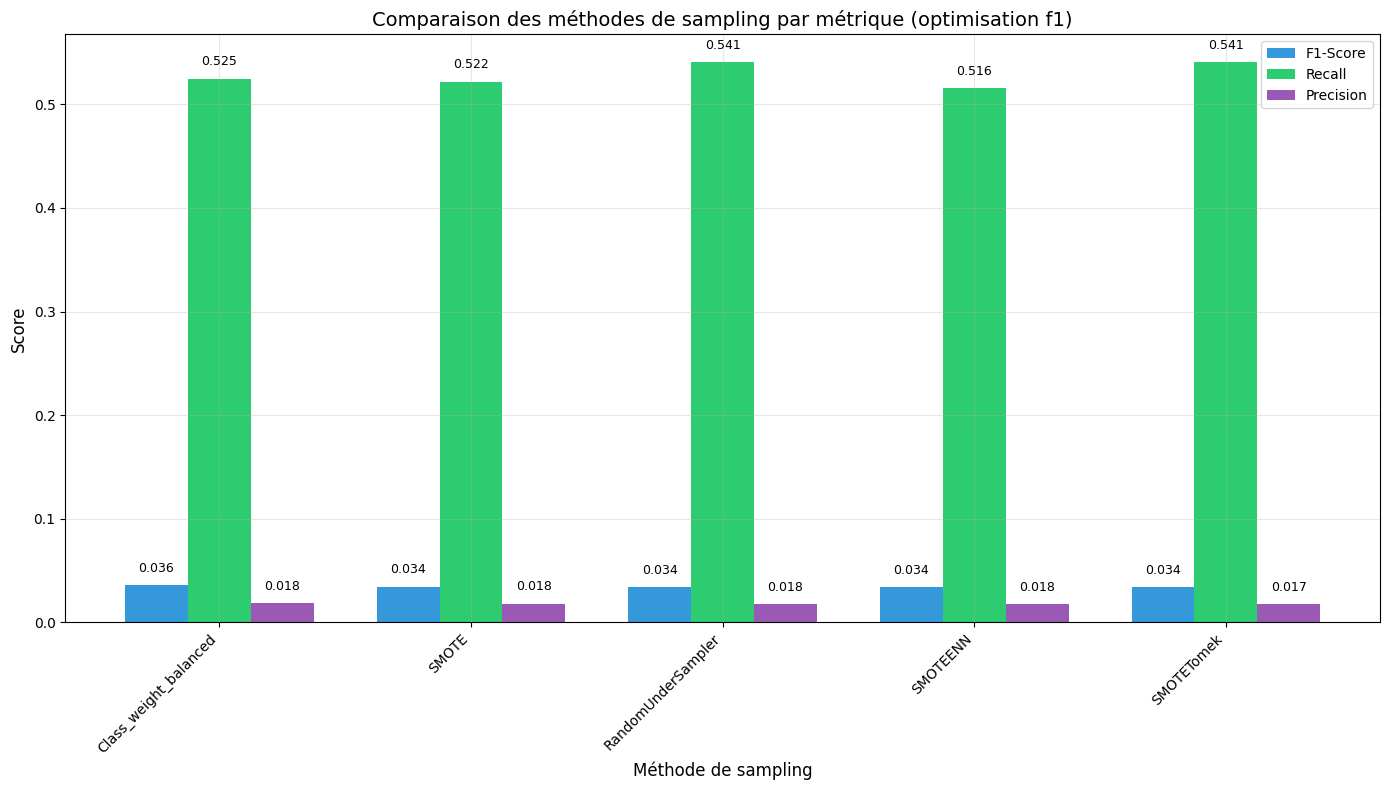

In [66]:
# Gridsearch pour optimiser le F1-score
resultats_grid_f1= optimize_model_with_sampling(X_train, y_train, metric_to_optimize='f1', use_mlflow=False)

##### L'analyse de ce graphique révèle que la méthode class_weight_balanced présente le meilleur f1_score, bien qu'il reste très faiblement supérieur aux autres (environ 0.2%). Cependant, en examinant le trade-off precision/recall, nous pourrions privilégier la technique de sous-échantillonnage qui, malgré un f1_score légèrement inférieur à 0.2%, offre un recall supérieur atteignant 54% (soit 2% supérieur), ce qui pourrait être plus pertinent selon notre objectif.

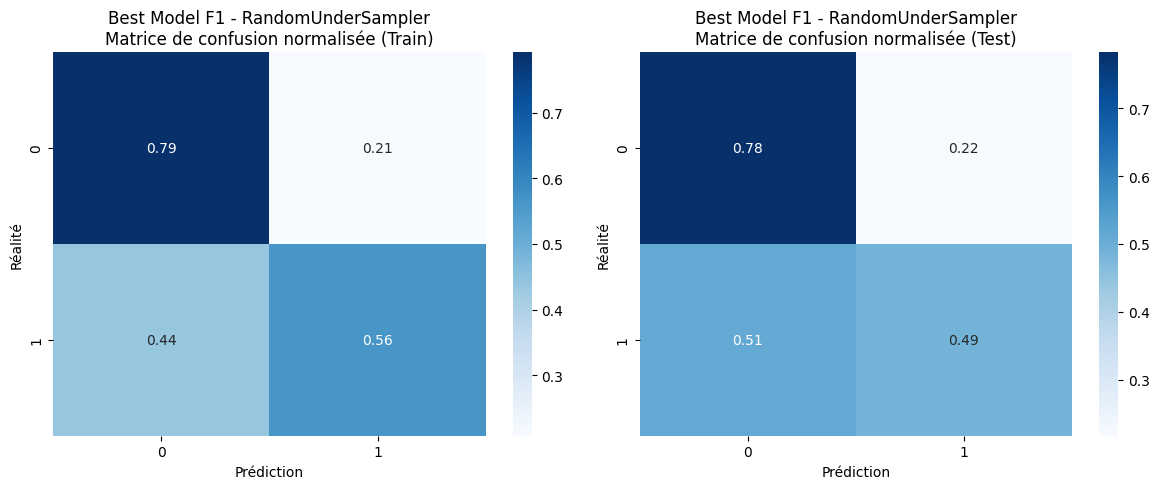

In [67]:
### Evaluation du meilleur modèle optimisé pour le F1-score

Name_Best_estimator='RandomUnderSampler'
Best_estimator=resultats_grid_f1[Name_Best_estimator]['meilleur_estimateur']

Best_model_f1=evaluate_model(Best_estimator, X_train,X_test,y_train,y_test,experiment_name="Optimisation F1",run_name=f"Best Model F1 - {Name_Best_estimator}",use_mlflow=False,display_plots=False)



### 3.2 Optimisation du recall

MLflow désactivé - Les résultats seront affichés uniquement dans le notebook

Évaluation de la méthode: Sans resampling
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs paramètres: {'classifier__solver': 'saga', 'classifier__class_weight': 'balanced', 'classifier__C': 1}
Meilleur score F1: 0.0355
Recall correspondant: 0.5250
Precision correspondante: 0.0184

Évaluation de la méthode: SMOTE
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs paramètres: {'sampler__sampling_strategy': 1.0, 'sampler__k_neighbors': 5, 'classifier__solver': 'liblinear', 'classifier__class_weight': 'balanced', 'classifier__C': 0.1}
Meilleur score F1: 0.0345
Recall correspondant: 0.5125
Precision correspondante: 0.0178

Évaluation de la méthode: RandomUnderSampler
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Meilleurs paramètres: {'sampler__sampling_strategy': 1.0, 'classifier__solver': 'saga', 'classifier__class_weight': 'balanced', 'classifier__C': 0.1}


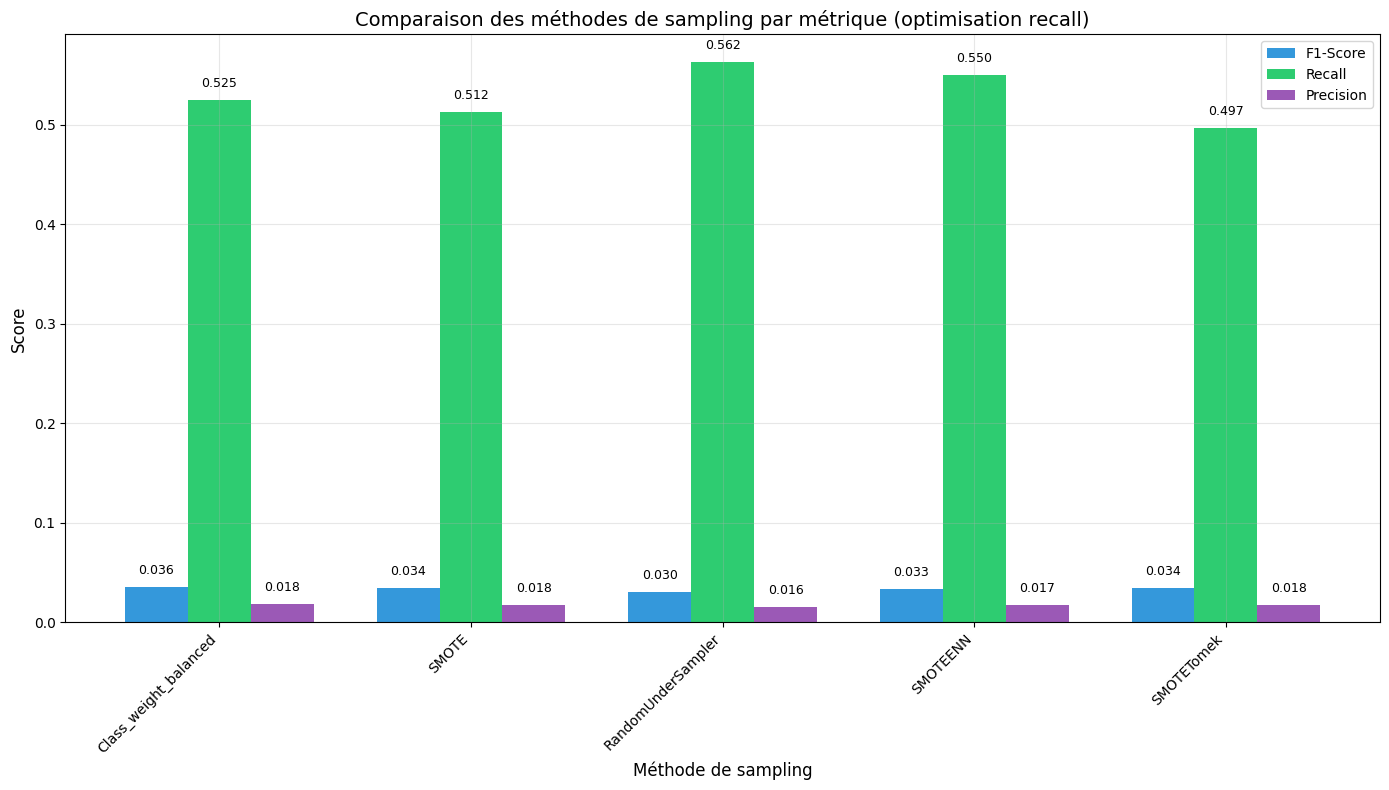

In [68]:
resultats_grid_recall= optimize_model_with_sampling(X_train, y_train, metric_to_optimize='recall',use_mlflow=False)

##### De meme ici la technique RandomUnderSampler offre le meilleur score recall avec un f1-score quasi équivalent aux autres méthodes

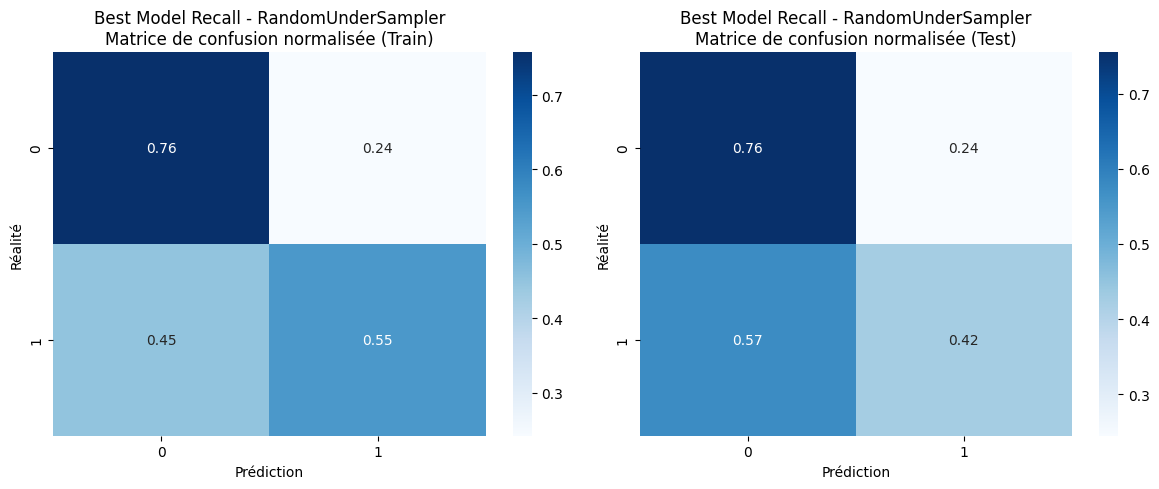

In [69]:
# Evaluation du meilleur modèle optimisé pour le recall


Name_Best_estimator='RandomUnderSampler'
Best_estimator=resultats_grid_recall[Name_Best_estimator]['meilleur_estimateur']

Best_model_recall=evaluate_model(Best_estimator, X_train,X_test,y_train,y_test,experiment_name="Optimisation Recall",run_name=f"Best Model Recall - {Name_Best_estimator}",use_mlflow=False,display_plots=False)


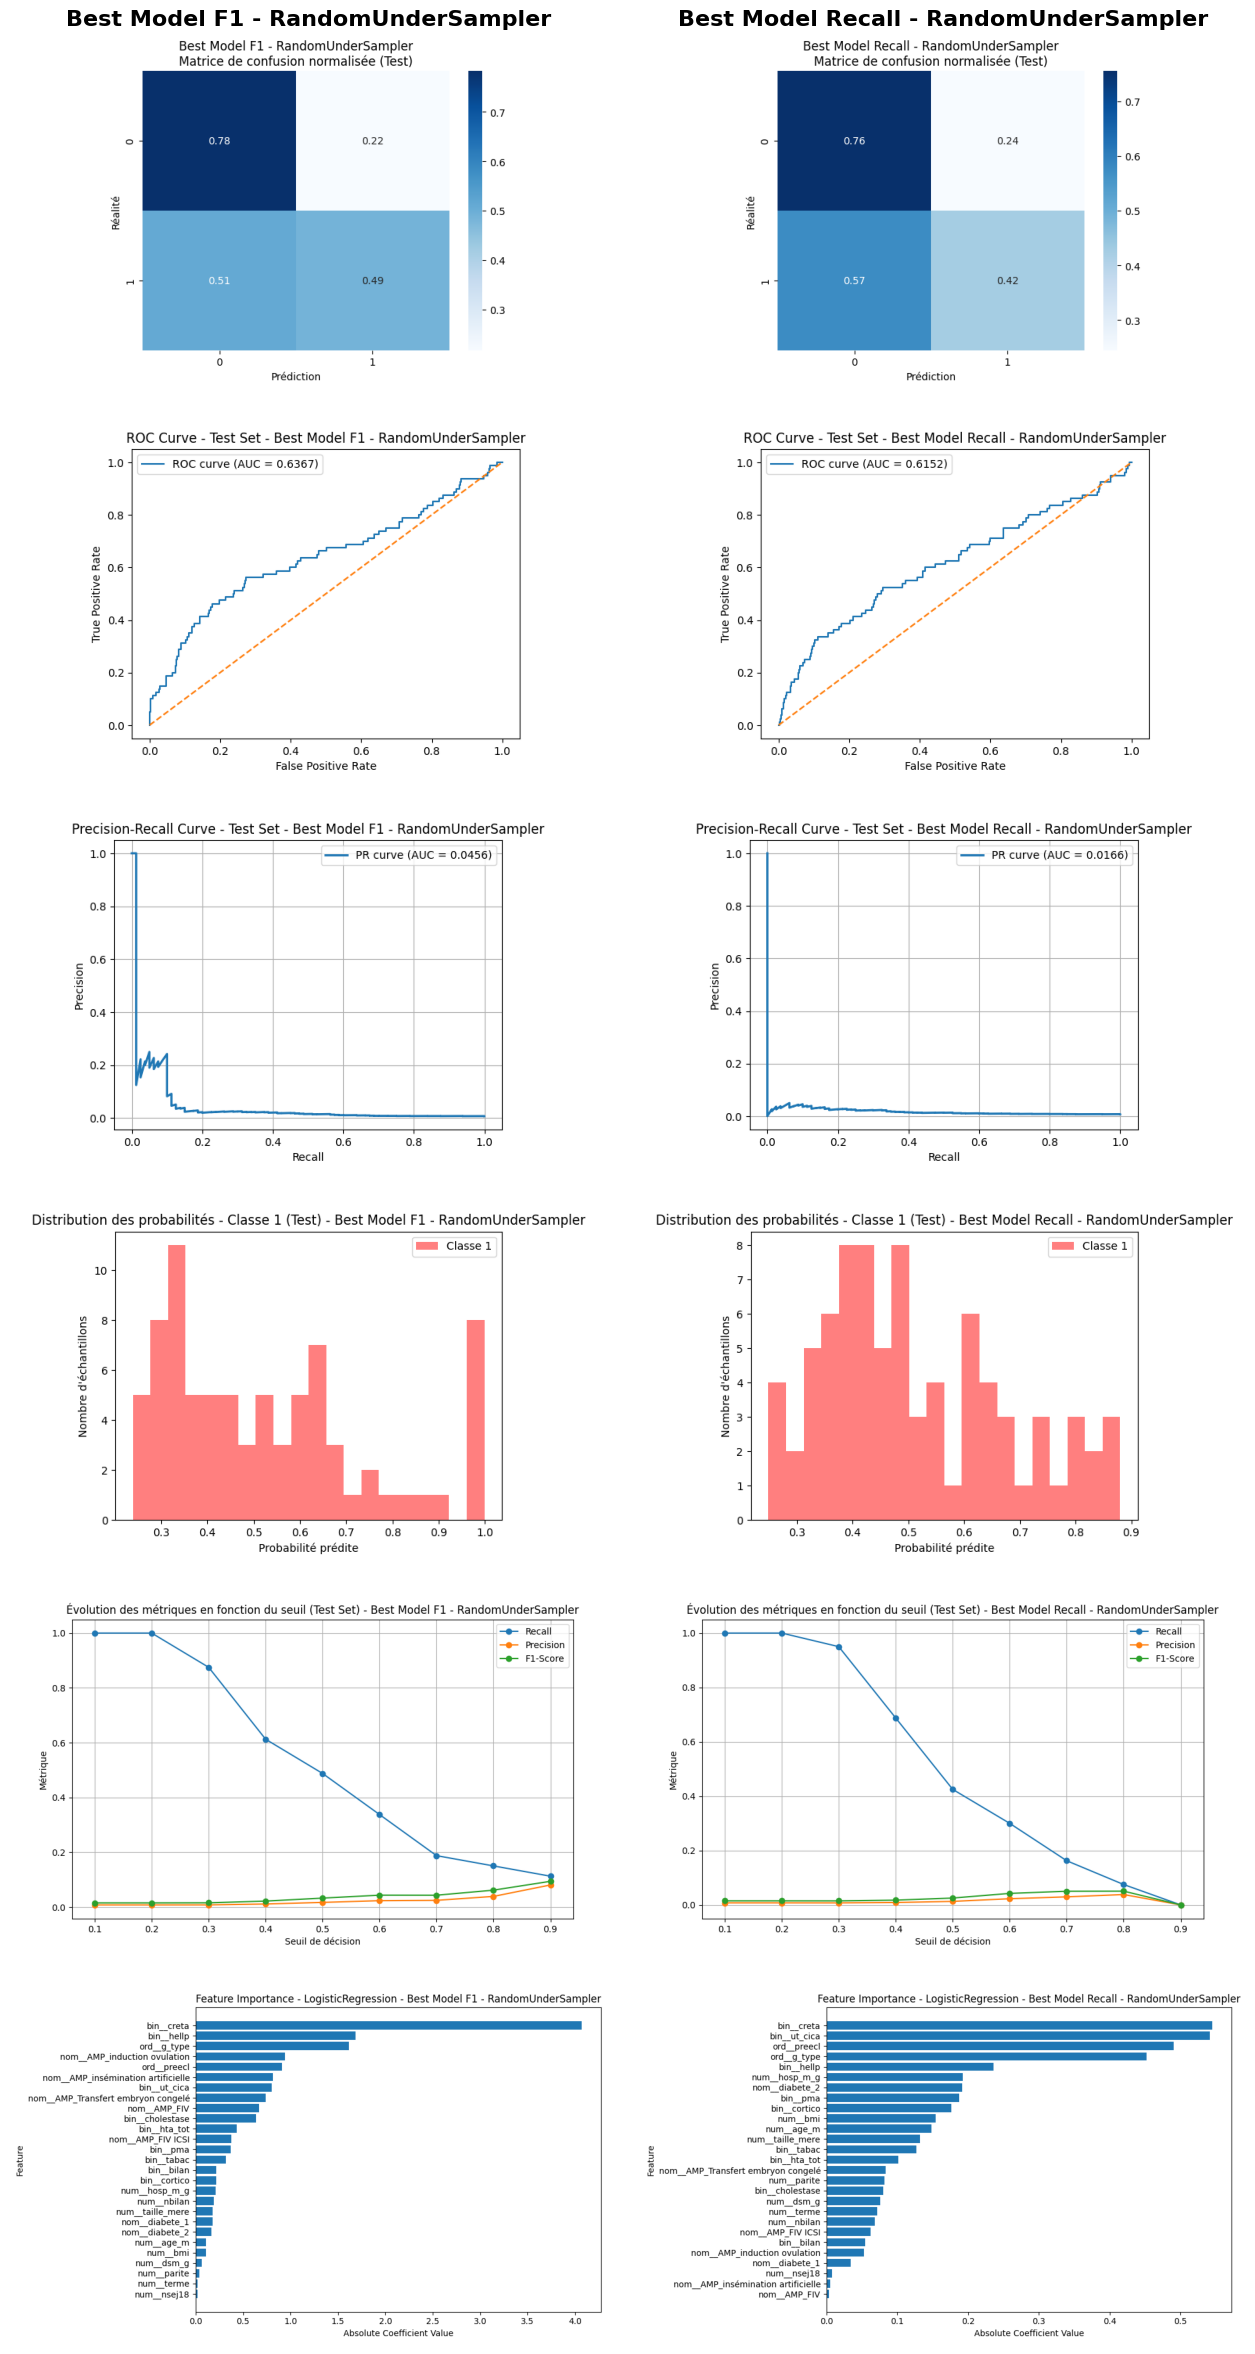

In [70]:

# Comparaison des modèles optimisés

comparer_modeles_visuellement([Best_model_f1,Best_model_recall],modeles_en_lignes=False)